1. Import required modules

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2. Import the dataset

In [ ]:
'''
Import data from CSV file

Inputs:
N/A

Outputs:
Sig0    : array
    Initial principal stresses (contains 3 elements)
ixSv    : int
    Vertical principal stress index (1, 2, or 3)
p0      : float
    Initial pore pressure
strike  : int
    Strike fault orientation in degrees
dip     : int
    Dip fault orientation in degrees
SHdir   : int
    Maximum horizontal stress direction in degrees
dp      : float
    Pressure pertubation
mu      : float
    Friction coefficient
APhi    : float, optional
    Friction angle parameter, default: None
ref_mu  : float, optional
    Reference friction angle, default: None
biot    : float, optional
    Biot coefficient (Poroelasticity), default: 1.0
nu      : float, optional
    Poisson's ratio (Poroelasticity), default: 0.5
'''

def import_data():
    df = pd.read_csv('input.csv')

    Sig0 = df[df.columns[0]].apply(lambda x: list(map(int, x.split(',')))).tolist()
    ixSv = df[df.columns[1]].tolist()
    strike = df[df.columns[2]].tolist()
    dip = df[df.columns[3]].tolist()
    SHdir = df[df.columns[4]].tolist()
    p0 = df[df.columns[5]].tolist()
    dp = df[df.columns[6]].tolist()
    mu = df[df.columns[7]].tolist()
    biot = df[df.columns[8]].tolist()
    nu = df[df.columns[9]].tolist()

    return Sig0, ixSv, strike, dip, SHdir, p0, dp, mu, biot, nu

In [54]:
'''
Calculate horizontal stresses from critical stress assumptions

Inputs:
APhi    : float
    Stress estimation parameter
Sv      : float
    Vertical stress
ref_mu  : float
    Friction angle in degrees
p0      : float
    Pore pressure

Outputs:
SH  : float
    Maximum horizontal stress
Sh  : float
    Minimum horizontal stress
'''

def get_hor_from_APhi(APhi, Sv, ref_mu, p0):
    if 0 <= APhi < 1:
        n = 0
    elif 1 <= APhi < 2:
        n = 1
    elif 2 <= APhi <= 3:
        n = 2

    Phi = (APhi - (n + 0.5)) / (-1)**n + 0.5
    k = (ref_mu + np.sqrt(1 + ref_mu**2))**2

    if n == 0:
        Sh = (Sv - p0) / k + p0
        SH = Phi * (Sv - Sh) + Sh
    elif n == 1:
        A = np.array([[1, -k], [Phi, 1 - Phi]])
        b = np.array([p0 - k * p0, Sv])
        x = np.linalg.solve(A, b)

        SH = x[0]
        Sh = x[1]
    elif n == 2:
        SH = k * (Sv - p0) + p0
        Sh = Phi * (SH - Sv) + Sv

    return SH, Sh

In [55]:
'''
Calculate 3D Mohr's Circle for stress analysis

Inputs:
Sig01   : int
    Initial maximum principal stresses
Sig02   : int
    Initial intermediate principal stresses
Sig03   : int
    Initial minimum principal stresses
ixSv    : int
    Vertical principal stress index (1, 2, or 3)
strike  : int
    Strike fault orientation in degrees
dip     : int
    Dip fault orientation in degrees
SHdir   : int
    Maximum horizontal stress direction in degrees
p0      : float
    Initial pore pressure
dp      : float
    Pressure pertubation
mu      : float
    Friction coefficient
APhi    : float, optional
    Friction angle parameter, default: None
ref_mu  : float, optional
    Reference friction angle, default: None
biot    : float, optional
    Biot coefficient (Poroelasticity), default: 1.0
nu      : float, optional
    Poisson's ratio (Poroelasticity), default: 0.5

Outputs:
ppfail      : float
    Pore pressure at failure (effective normal stress)
cff         : float
    Couloumb failure function
scu         : float
    Shear capacity utilization
sig_fault   : array
    Effective normal stress on fault
tau_fault   : array
    Effective shear stress on fault 
'''

def mohrs_3D_v2(Sig01, Sig02, Sig03, ixSv, strike, dip, SHdir, p0, dp, mu, APhi = None, ref_mu = None, biot = 1, nu = 0.5):
    Sig0 = [Sig01, Sig02, Sig03]

    if len(Sig0) != 3:
        raise ValueError(f'Sig0 should include 3 elements. You have {len(Sig0)} elements.')

    if ixSv not in [1, 2, 3]:
        raise ValueError(f'ixSv should be 1, 2, or 3. You have ixSv = {ixSv}.')

    # Sort initial stresses in descending order
    Sig0 = np.sort(Sig0)[::-1]

    # Determine vertical stress
    Sv = Sig0[int(ixSv) - 1]

    # Compute horizontal stresses using APhi (if provided)
    if APhi is not None and ref_mu is not None:
        if APhi < 0 or APhi > 3:
            raise ValueError(f'APhi should be in range [0,3]. You have APhi = {APhi}.')

        SH, Sh = get_hor_from_APhi(APhi, Sv, ref_mu, p0)

        if ixSv == 1:
            Sig0 = [Sv, SH, Sh]
        elif ixSv == 2:
            Sig0 = [SH, Sv, Sh]
        elif ixSv == 3:
            Sig0 = [SH, Sh, Sv]

    # Compute effective stresses
    Sig = np.array(Sig0) + biot * (1 - 2 * nu) / (1 - nu) * dp

    # Unit vectors
    uSH = [np.cos(np.deg2rad(SHdir)), np.sin(np.deg2rad(SHdir)), 0]
    uV = [0, 0, 1]

    # Direction cosines based on vertical stress index
    if ixSv == 1:
        uSh = np.cross(uV, uSH)
        uS3 = uSh
        uS2 = uSH
        uS1 = uV
    elif ixSv == 2:
        uSh = np.cross(uSH, uV)
        uS3 = uSh
        uS2 = uV
        uS1 = uSH
    elif ixSv == 3:
        uSh = np.cross(uV, uSH)
        uS3 = uV
        uS2 = uSh
        uS1 = uSH

    # Fault normal vector
    uF = [-np.sin(np.deg2rad(dip)) * np.sin(np.deg2rad(strike)), 
          np.sin(np.deg2rad(dip)) * np.cos(np.deg2rad(strike)), 
          -np.cos(np.deg2rad(dip))]

    # Effective stresses on fault
    Sigv = Sig - (p0 + dp)
    l = np.dot(uF, uS1)
    m = np.dot(uF, uS2)
    n = np.dot(uF, uS3)

    sig_fault = Sigv[0] * l**2 + Sigv[1] * m**2 + Sigv[2] * n**2
    tau_fault = np.sqrt((Sigv[0] * l)**2 + (Sigv[1] * m)**2 + (Sigv[2] * n)**2 - sig_fault**2)

    # Calculate outputs
    ppfail = sig_fault - tau_fault / mu
    cff = tau_fault - mu * sig_fault
    scu = tau_fault / (mu * sig_fault)

    # Calculate Mohr's Circle data
    R1 = 0.5 * (Sig0[0] - Sig0[2])
    R2 = 0.5 * (Sig0[1] - Sig0[2])
    R3 = 0.5 * (Sig0[0] - Sig0[1])

    # Circle plots
    angles = np.linspace(0, 2 * np.pi, 100)
    C1 = R1 * np.exp(1j * angles) + (Sig0[0] + Sig0[2]) / 2 - (p0 + dp)
    C2 = R2 * np.exp(1j * angles) + (Sig0[1] + Sig0[2]) / 2 - (p0 + dp)
    C3 = R3 * np.exp(1j * angles) + (Sig0[0] + Sig0[1]) / 2 - (p0 + dp)

    # Plotting
    plt.figure()
    plt.plot(np.real(C1), np.imag(C1), label = 'C1', color = 'blue')
    plt.plot(np.real(C2), np.imag(C2), label = 'C2', color = 'orange')
    plt.plot(np.real(C3), np.imag(C3), label = 'C3', color = 'green')
    plt.plot([0, Sig0[0]], mu * np.array([0, Sig0[0]]), 'r', linewidth = 2, label = 'Friction Line')
    plt.plot(sig_fault, tau_fault, 'og', markerfacecolor = 'g', label = 'Fault Point')

    plt.grid()
    plt.axis('equal')
    plt.xlim([0, Sig0[0]])
    plt.ylim([0, 2 * R1])
    plt.xlabel(r'$\sigma$ effective [bars]')
    plt.ylabel(r'$\tau$ [bars]')
    plt.legend()
    plt.title('Mohr\'s Circle Analysis for a Single Fault')
    plt.show()

    return ppfail, cff, scu, sig_fault, tau_fault

In [56]:
'''
Run Monte Carlo simulation on 3D Mohr's Circle function with stochastic inputs

Inputs:
f       : function
    Function handle
in0     : array
    Baseline inputs for f
inSig   : array
    Variance values for each element of in0
nruns   : int
    Monte Carlo runs, default: Uniform
dist    : str, default: Uniform
    Distribution ("Uniform", "Normal", or "Lognormal")

Outputs:
out     : Array
    Output values from each run
inj     : Array of arrays
    Perturbed input values for each run
'''

def monte_carlo(f, in0, inSig, nruns = 1000, dist = "Uniform"):
    # Preallocate output arrays
    out = np.zeros(nruns)
    inj = [in0.copy() for _ in range(nruns)]

    # Run Monte Carlo simulation
    for i in range(nruns):
        # Perturb each input according to specified distribution
        for j in range(len(in0)):
            if dist == "Uniform":
                inj[i][j] = np.random.uniform(in0[j] - inSig[j], in0[j] + inSig[j])
            elif dist == "Normal":
                inj[i][j] = np.random.normal(in0[j], inSig[j])
            elif dist == "Lognormal":
                inj[i][j] = np.random.lognormal(np.log(in0[j]), inSig[j])
            else:
                raise ValueError("Unknown distribution specified.")

        # Run function with perturbed inputs
        result = f(*inj[i])
        out[i] = result[0]

    return out, inj

In [57]:
'''
Pore pressure to failure Monte Carlo Calculation

Inputs:
indatacell : array
    Baseline inputs for mohrs_3D_v2 function
sigcell    : array
    Variance values for each element of indatacell
nruns      : int
    Monte Carlo runs, default: Uniform
dist    : str, default: Uniform
    Distribution ("Uniform", "Normal", or "Lognormal")

Outputs:
out     : Array
    Output values from Monte Carlo simulations
inj     : Array of arrays
    Perturbed input values ffrom Monte Carlo simulations
'''

def ppfail_MC(indatacell, sigcell, nruns = 1000, dist = "Uniform"):
    if indatacell is None or sigcell is None:
        raise ValueError(f'Either indatacell or sigcell is missing')

    outs, inj = monte_carlo(mohrs_3D_v2, indatacell, sigcell, nruns, dist)

    # Plot the figure
    plt.figure()
    plt.hist(outs, density = True, alpha = 0.7, color = "steelblue", ec = "black")
    plt.xlabel("Pore Pressure to Failure")
    plt.ylabel("Probability Density")
    plt.title("Probability Density Function of Monte Carlo Simulation Results")
    plt.grid(True)
    plt.show()

    return outs, inj

In [58]:
def main():
    Sig01, Sig02, Sig03, ixSv, strike, dip, SHdir, p0, dp, mu, APhi, ref_mu, biot, nu = import_data()
    indatacell = [Sig01, Sig02, Sig03, ixSv, strike, dip, SHdir, p0, dp, mu, APhi, ref_mu, biot, nu]
    ppfail, cff, scu, sig_fault, tau_fault = mohrs_3D_v2(Sig01, Sig02, Sig03, ixSv, p0, strike, dip, SHdir, dp, mu, APhi = None, ref_mu = None, biot = 1, nu = 0.5)
    outs, inj = ppfail_MC(indatacell, sigcell = None, nruns = 1000)

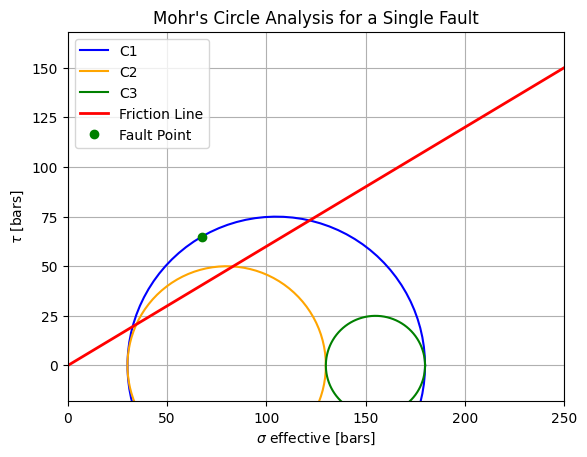

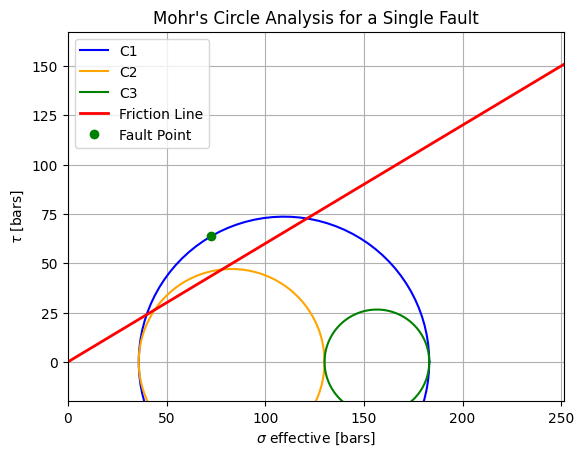

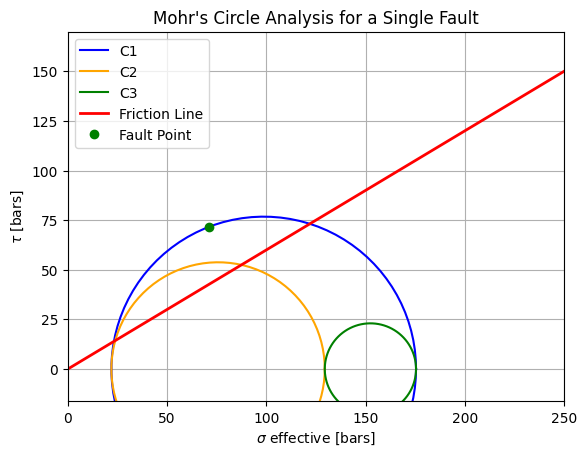

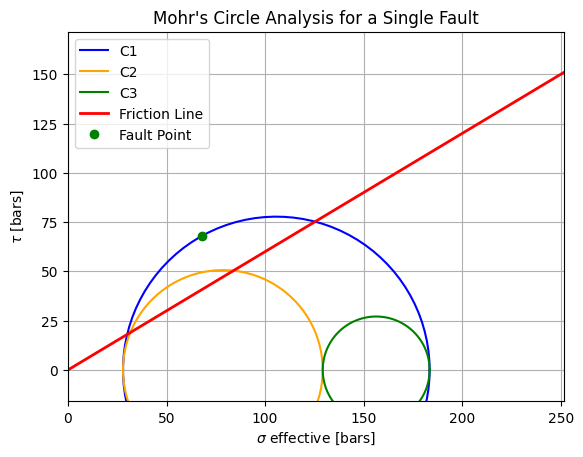

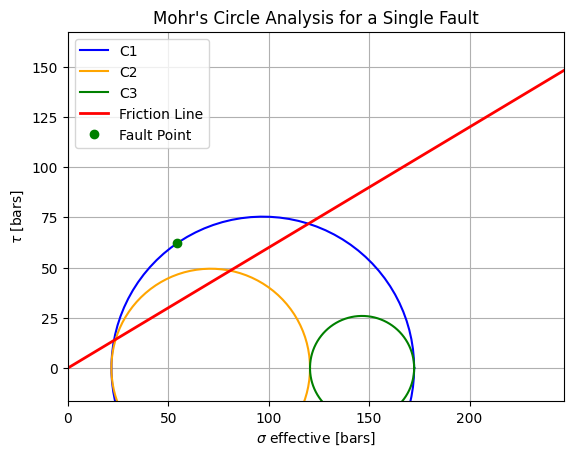

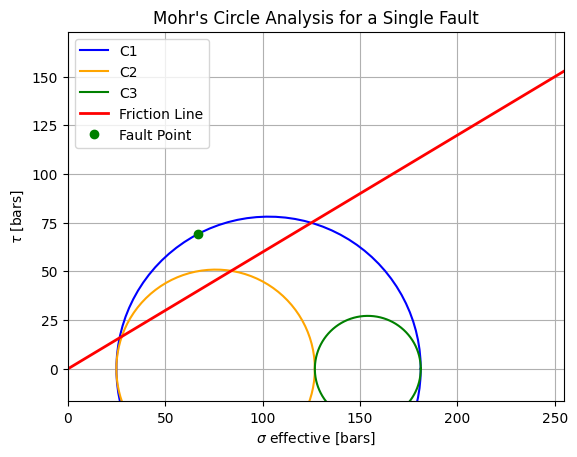

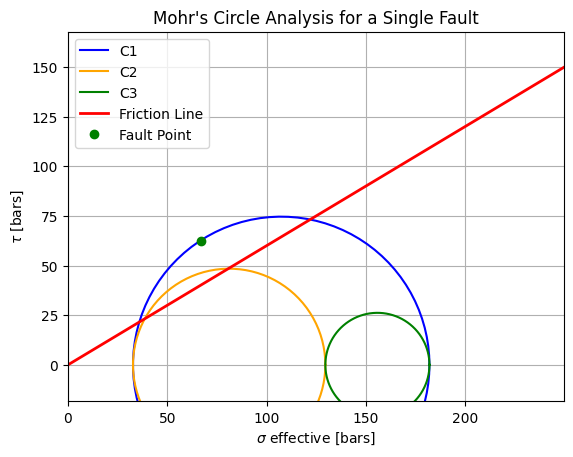

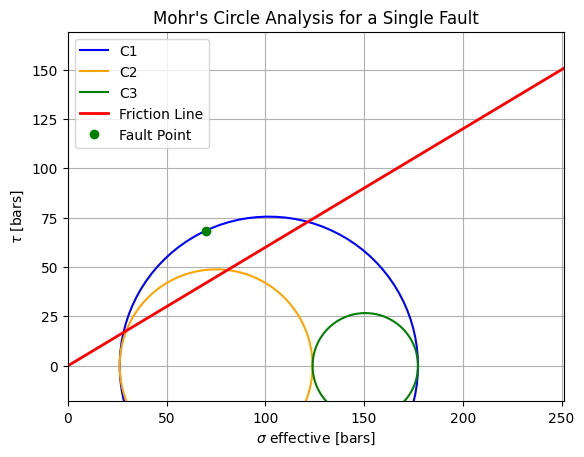

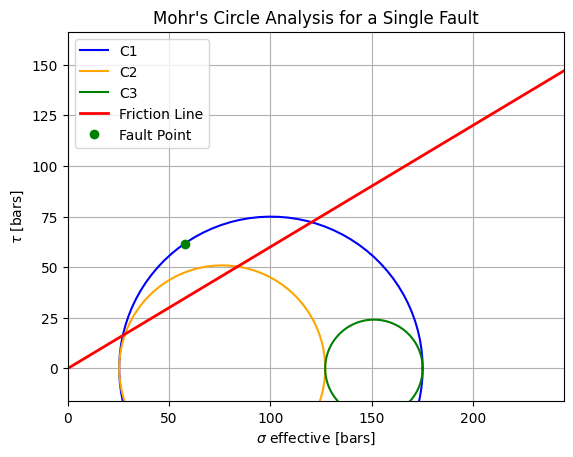

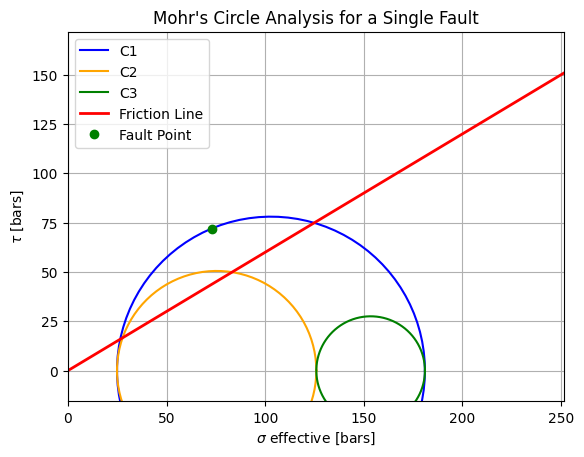

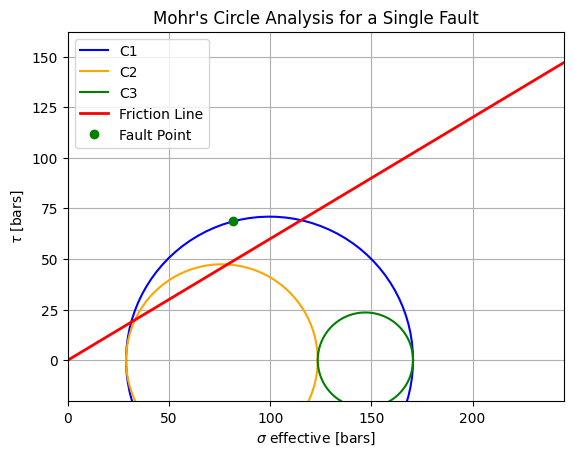

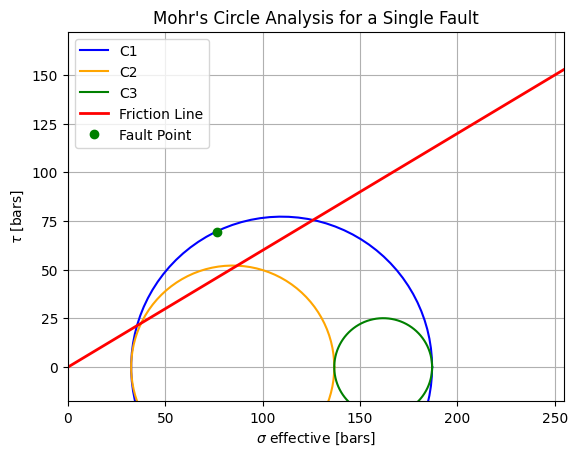

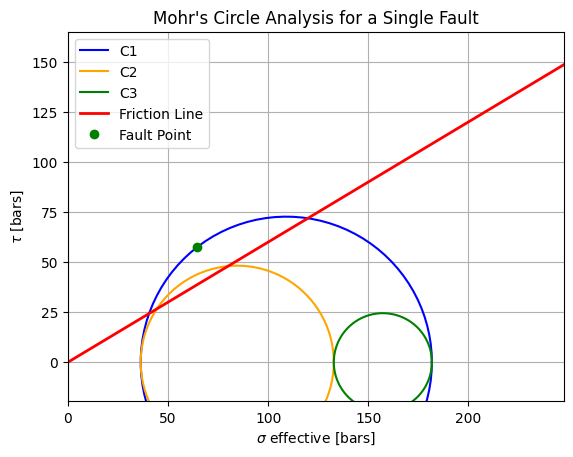

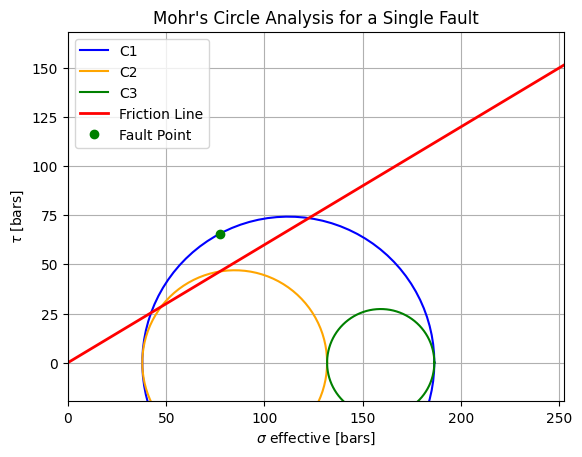

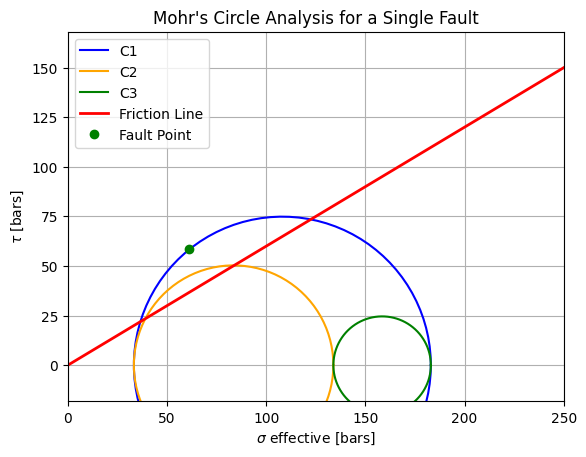

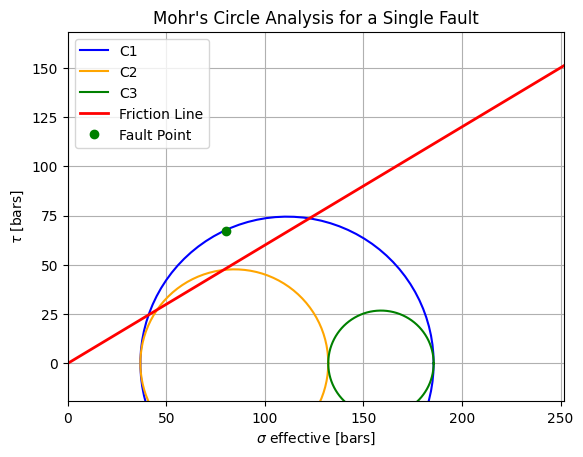

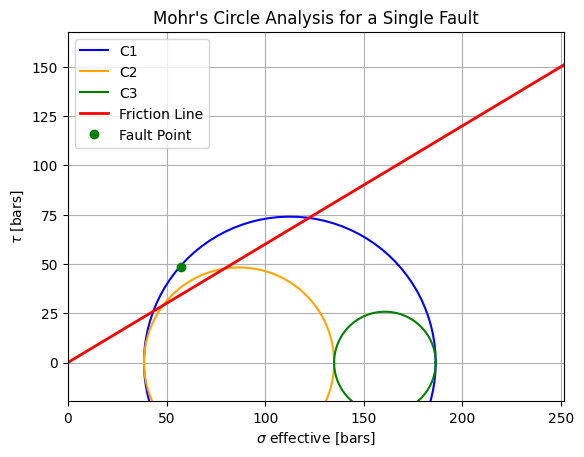

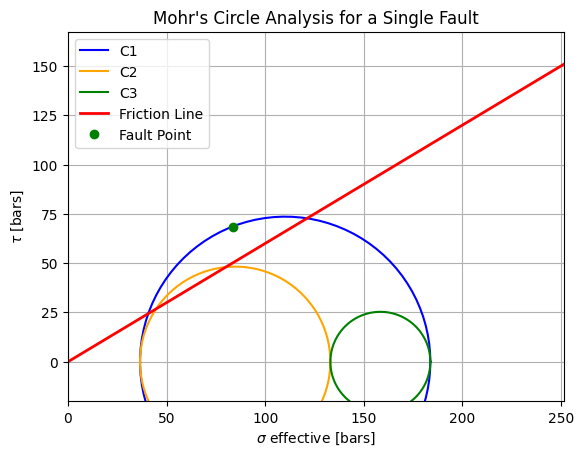

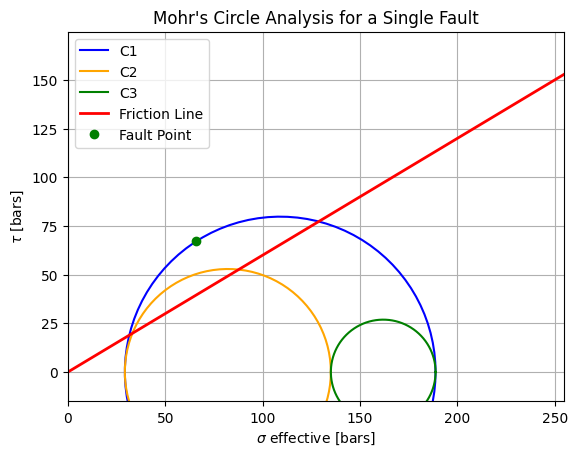

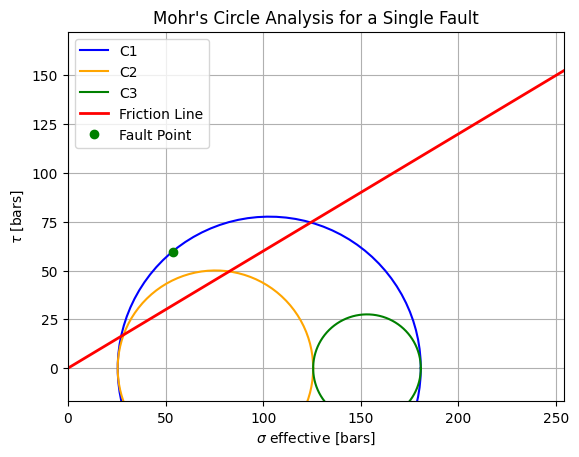

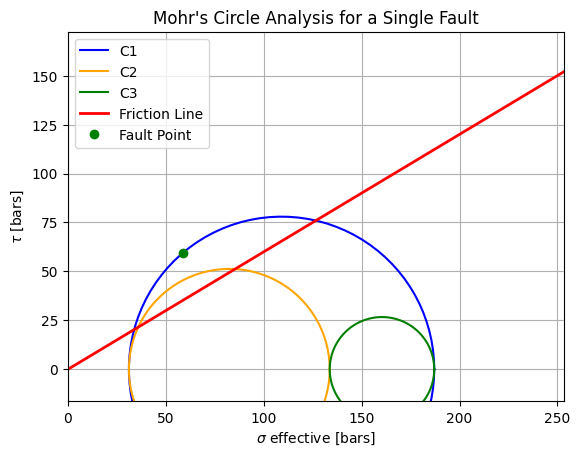

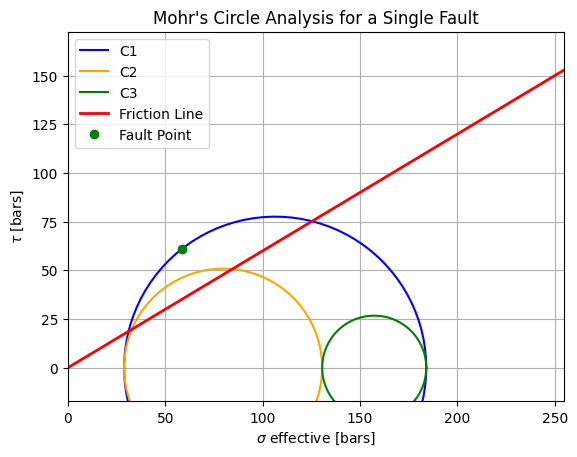

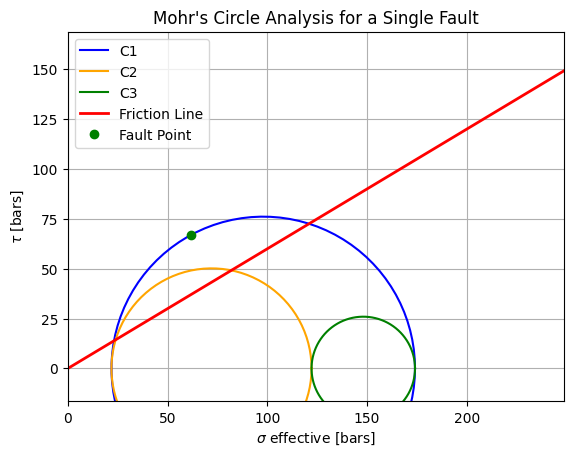

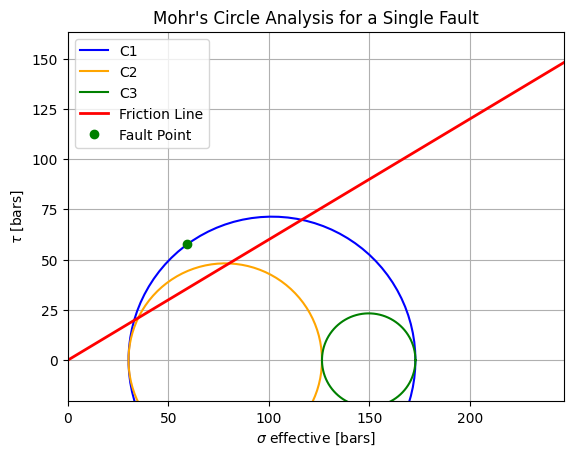

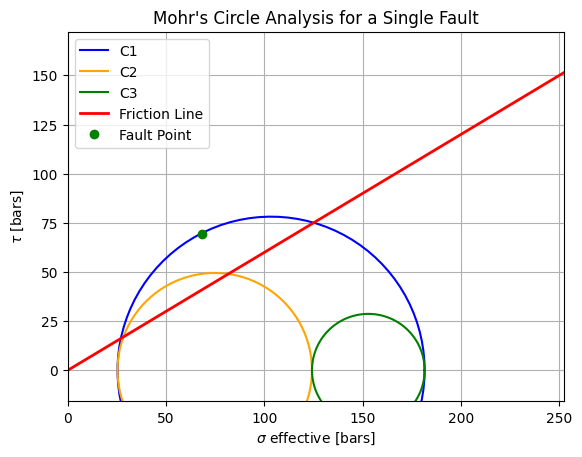

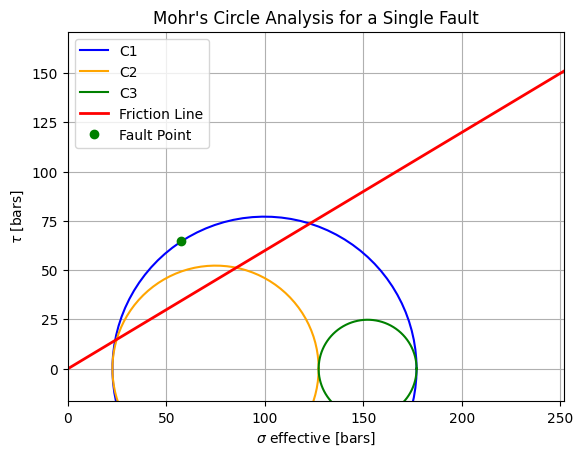

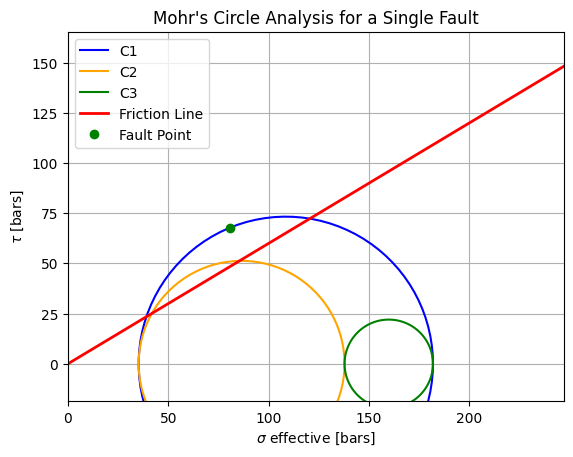

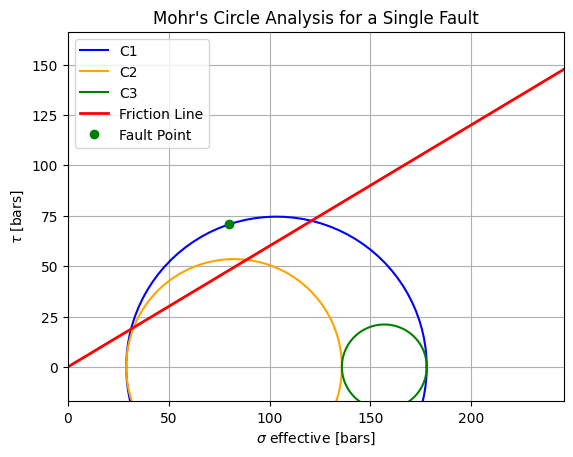

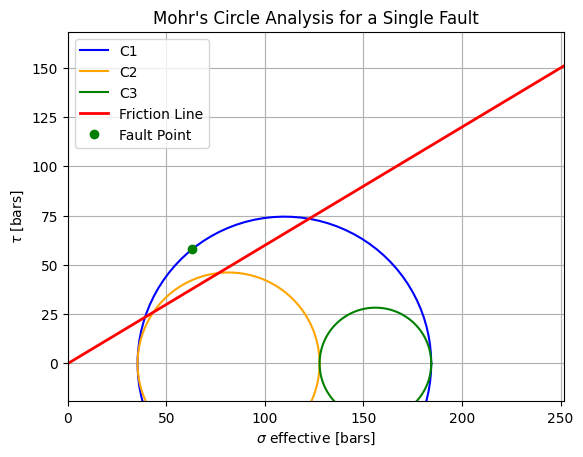

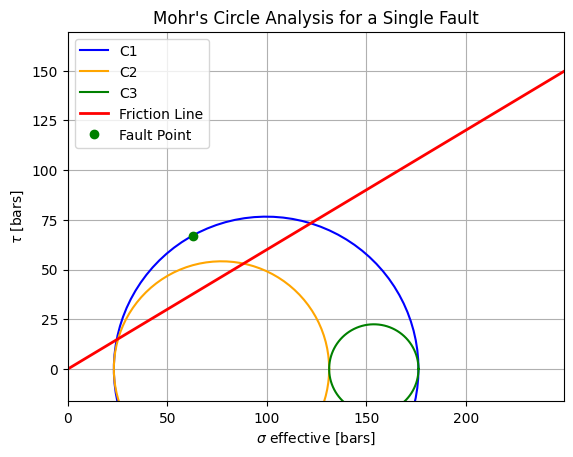

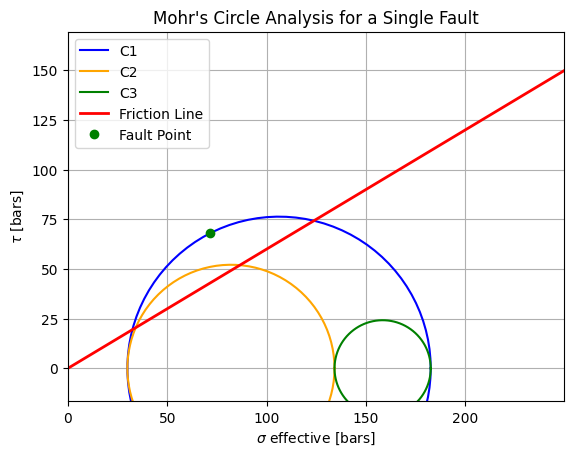

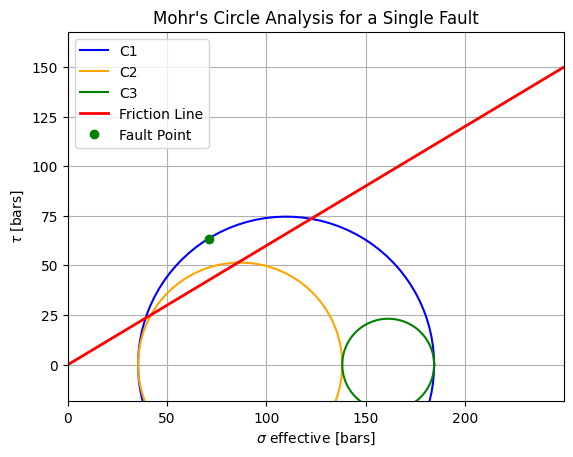

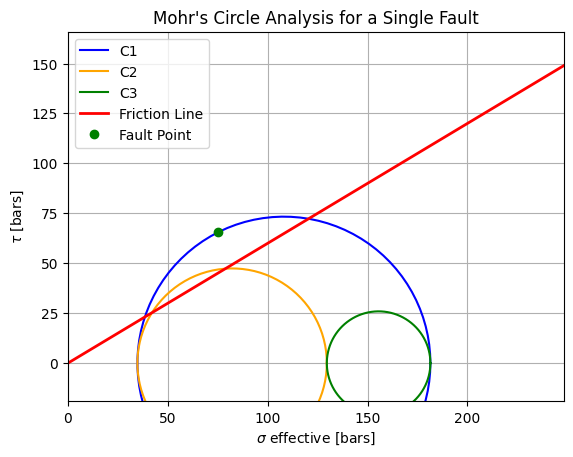

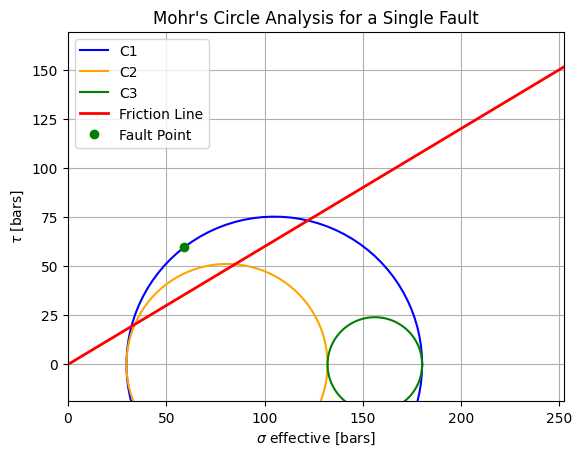

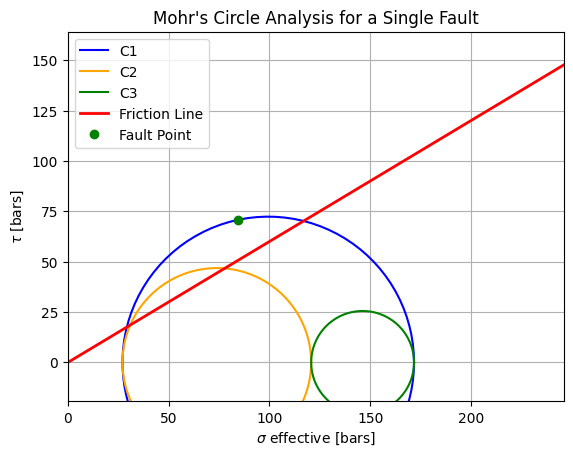

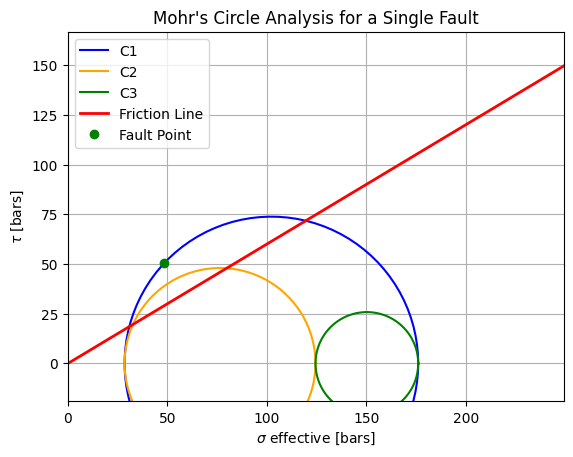

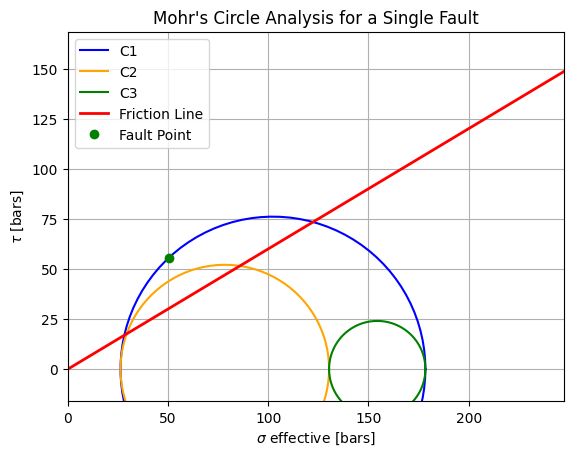

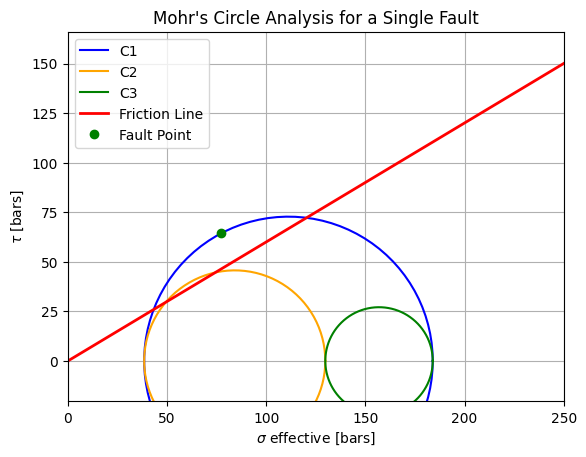

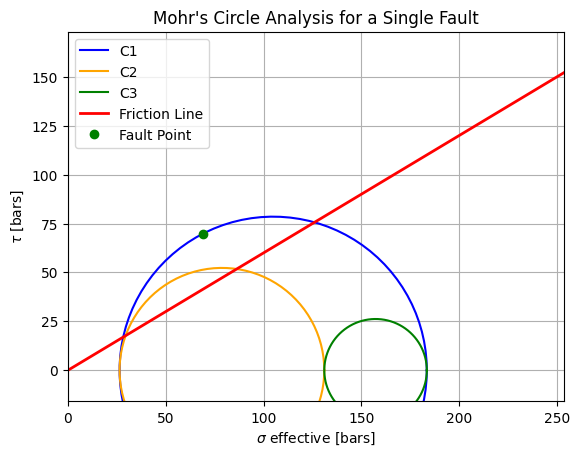

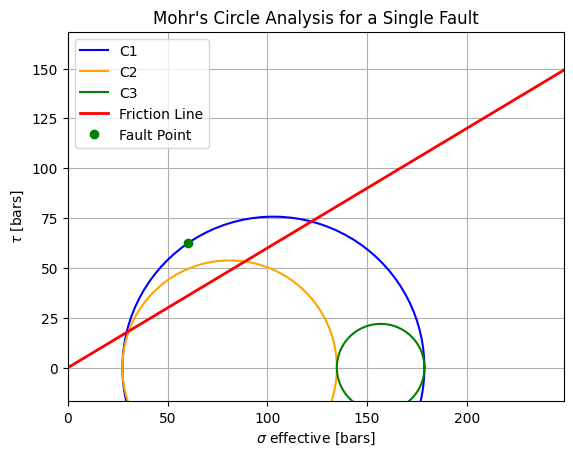

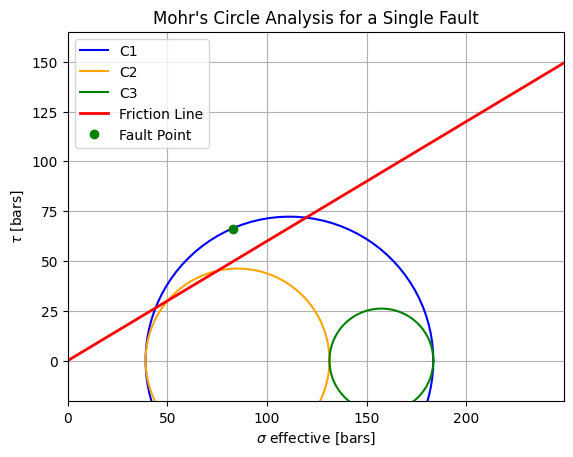

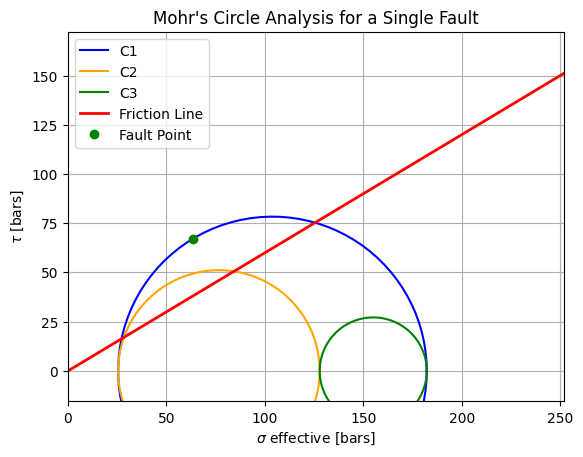

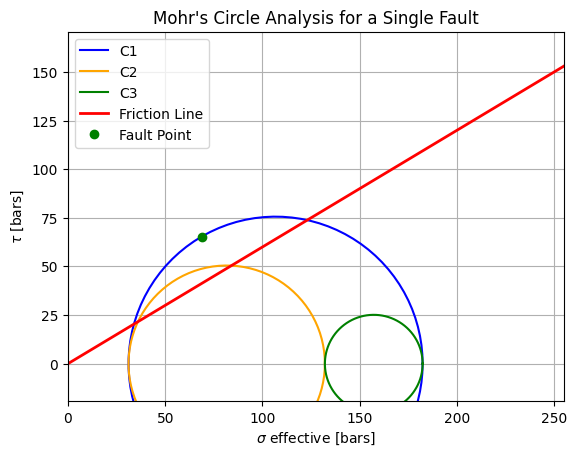

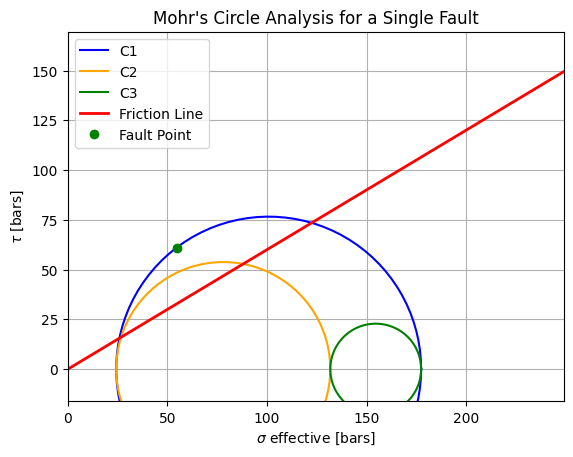

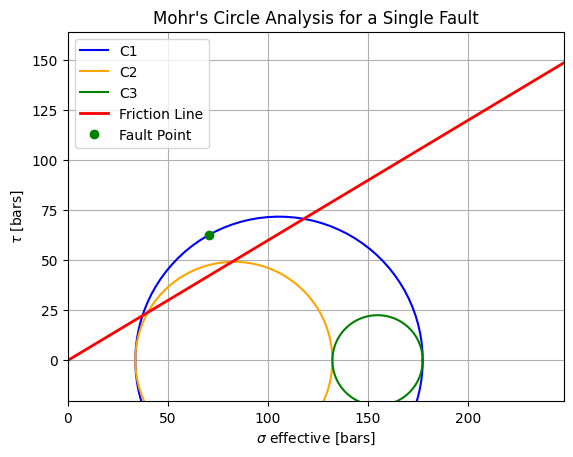

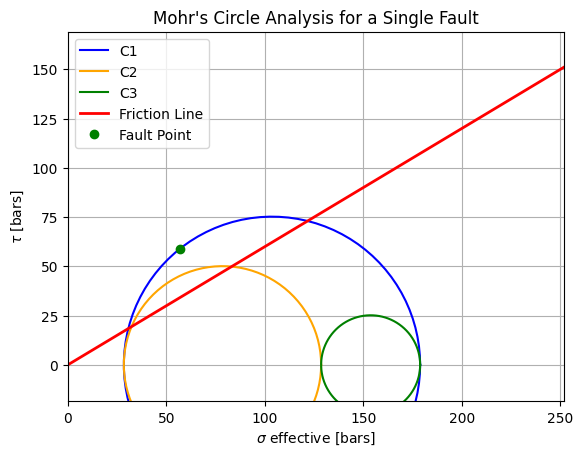

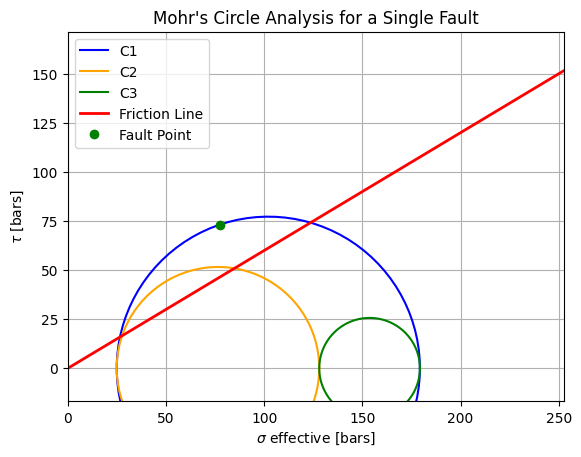

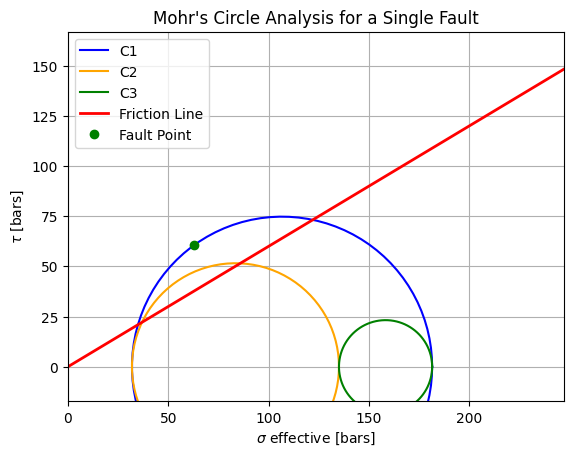

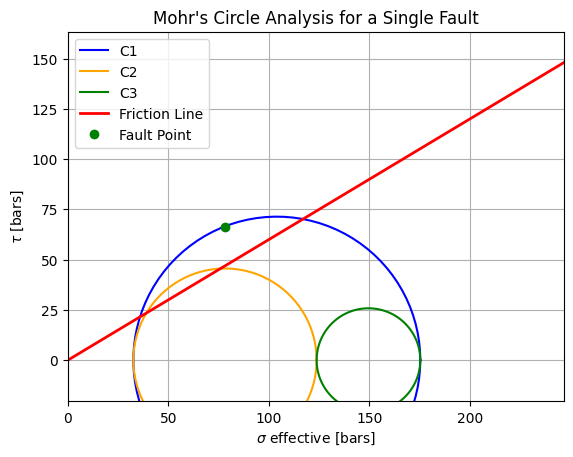

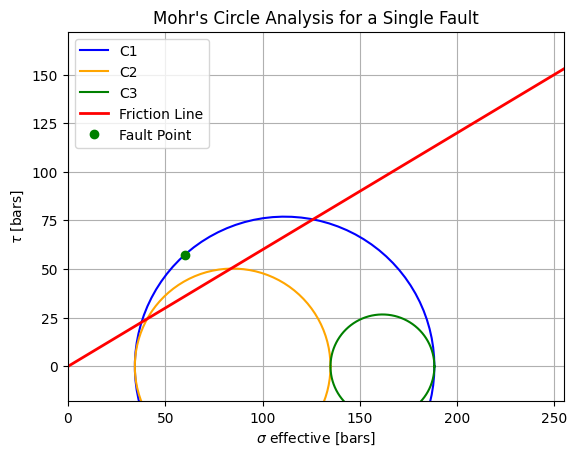

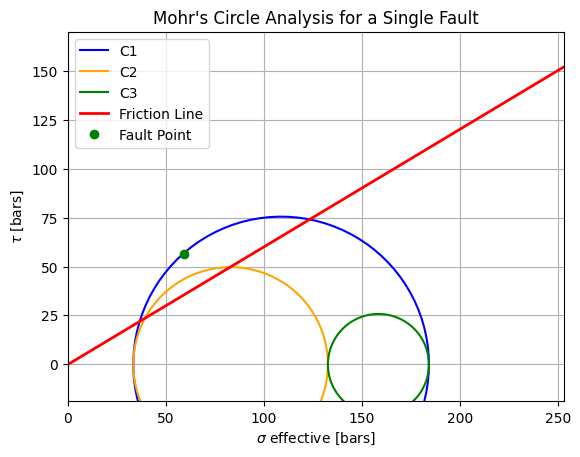

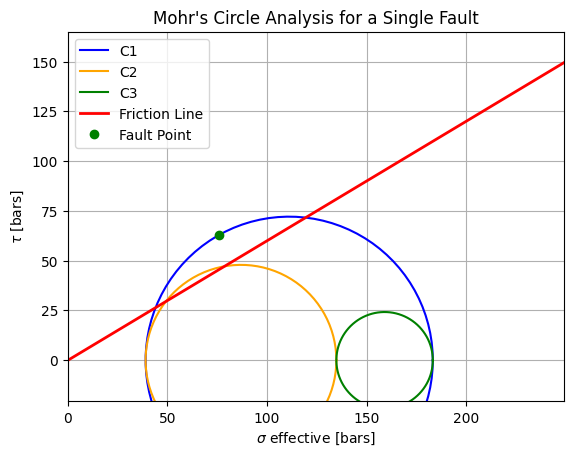

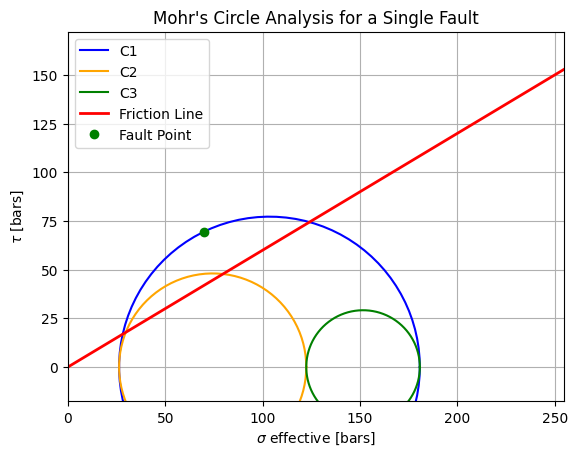

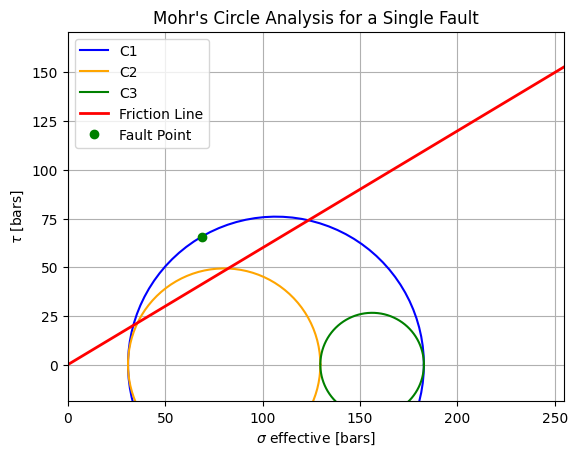

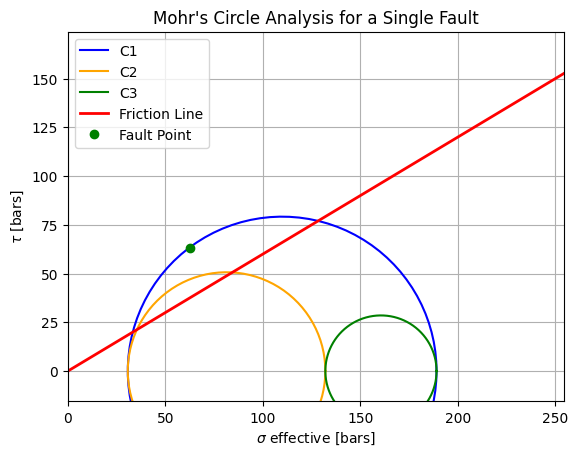

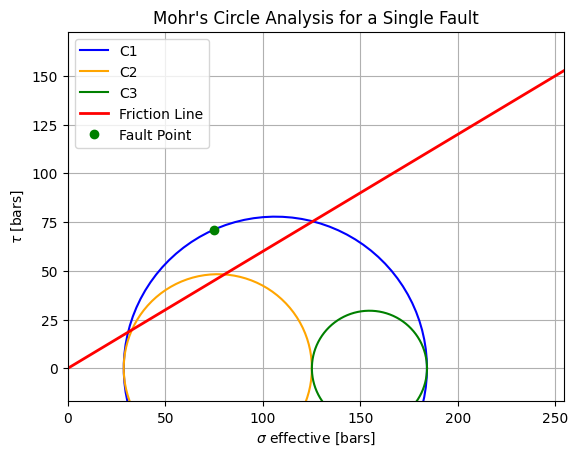

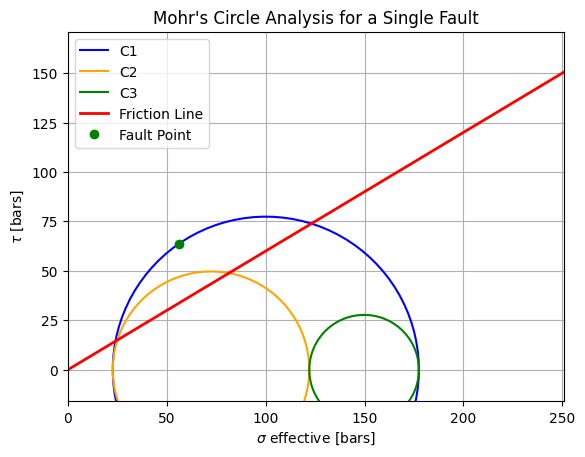

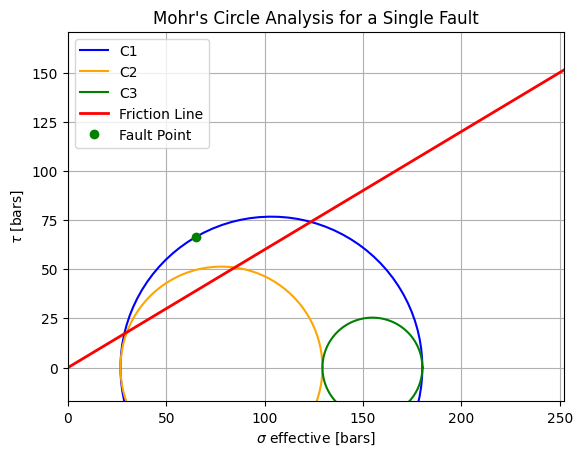

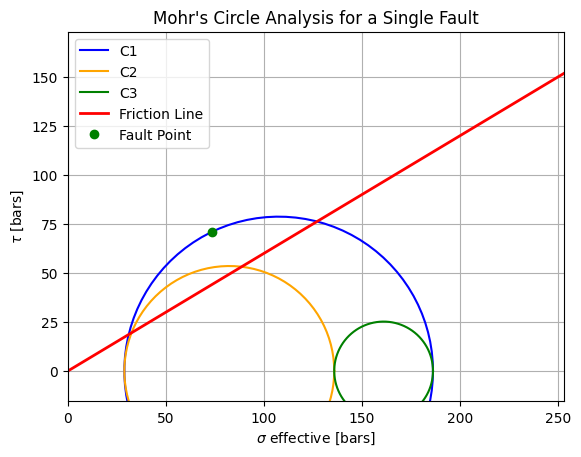

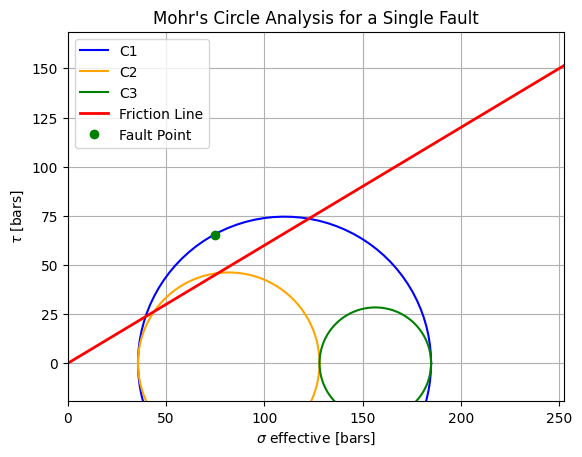

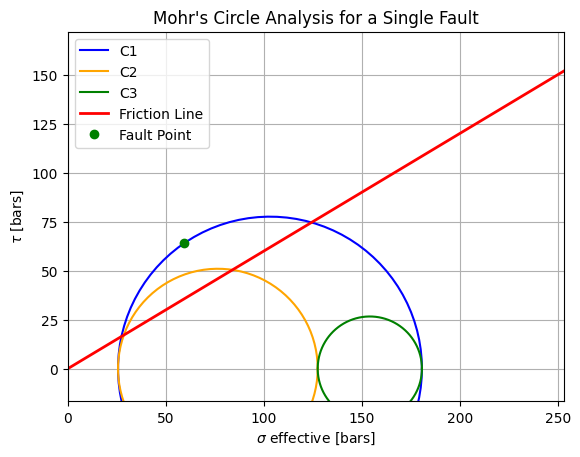

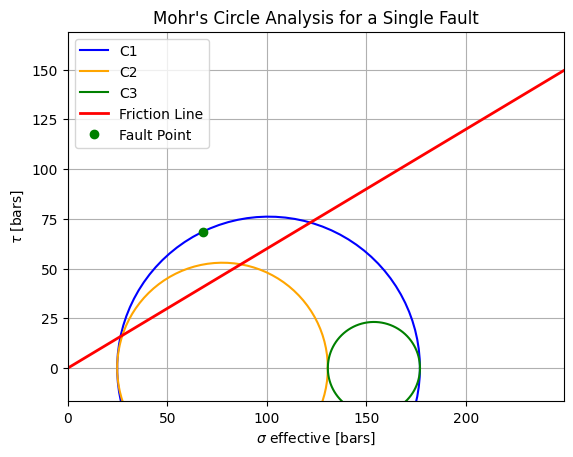

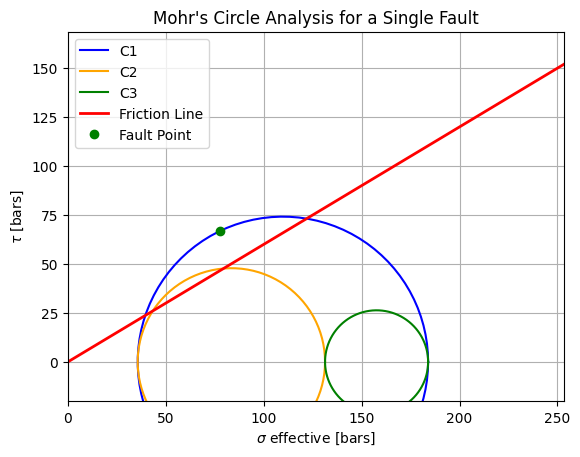

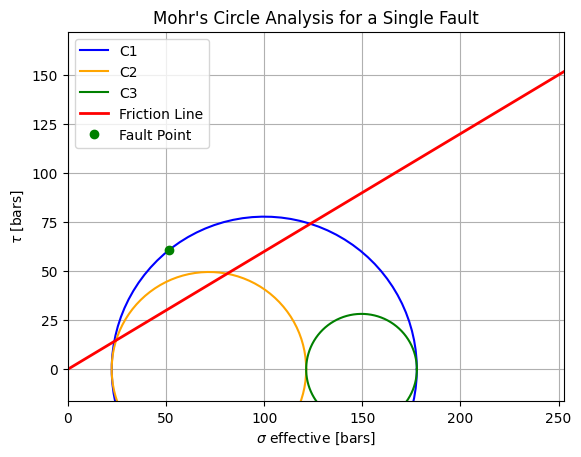

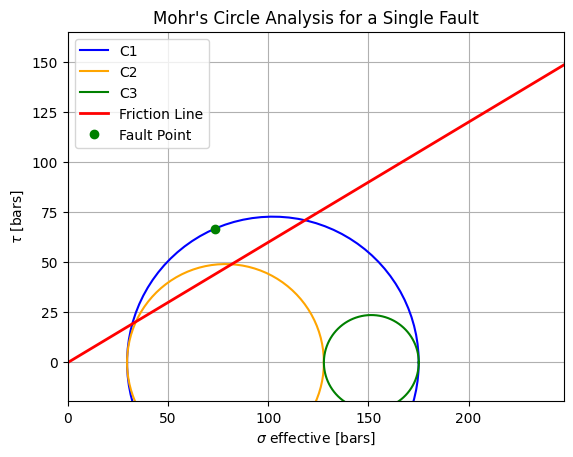

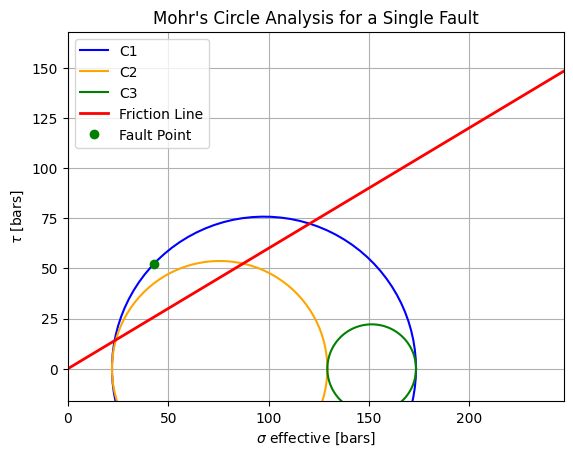

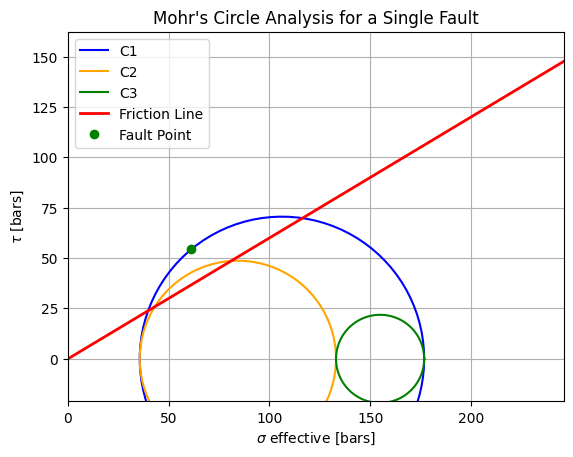

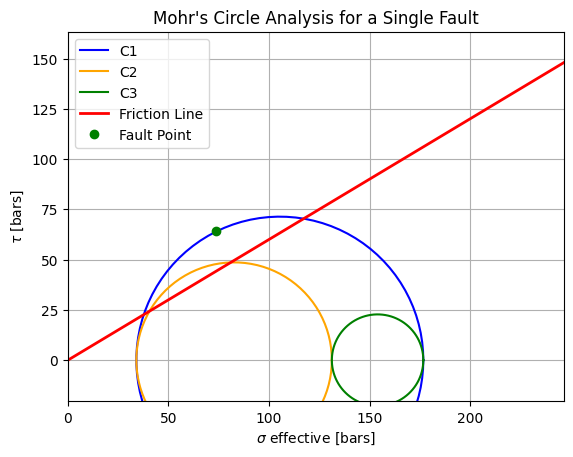

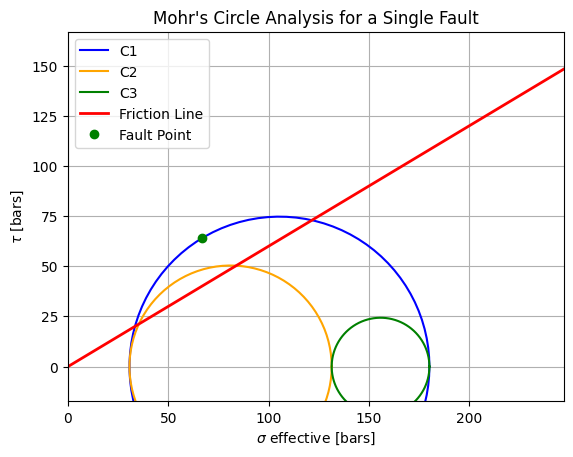

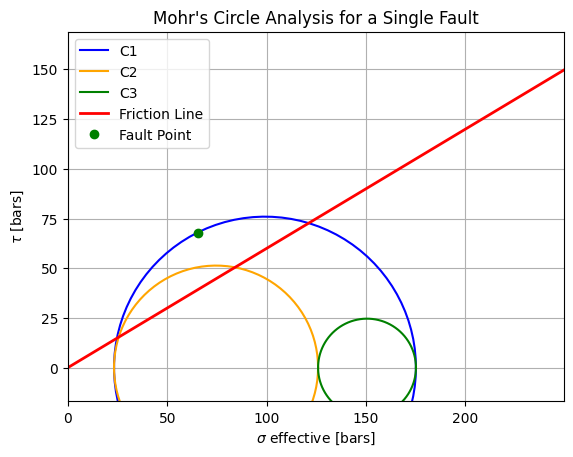

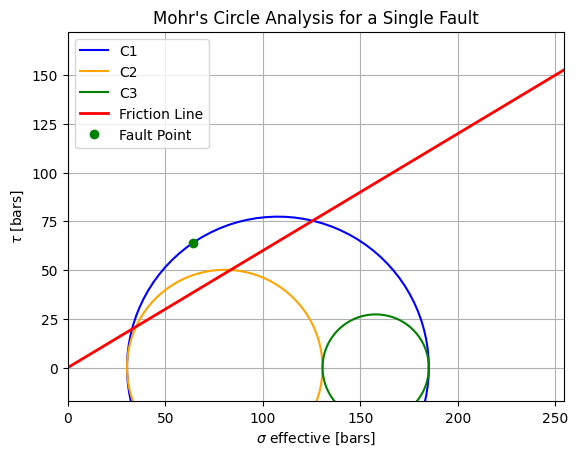

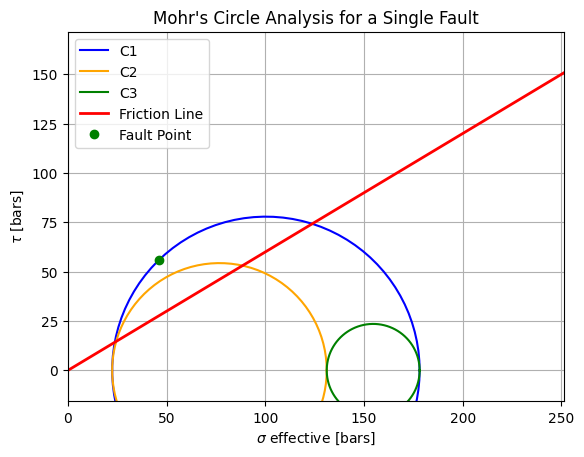

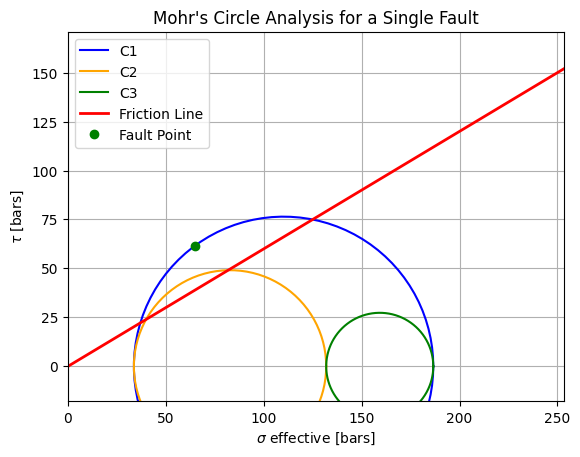

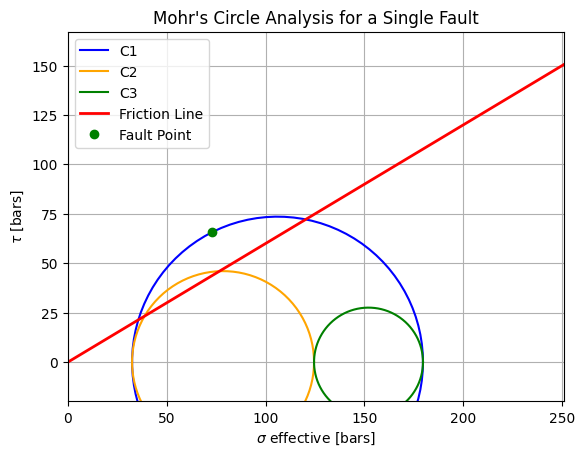

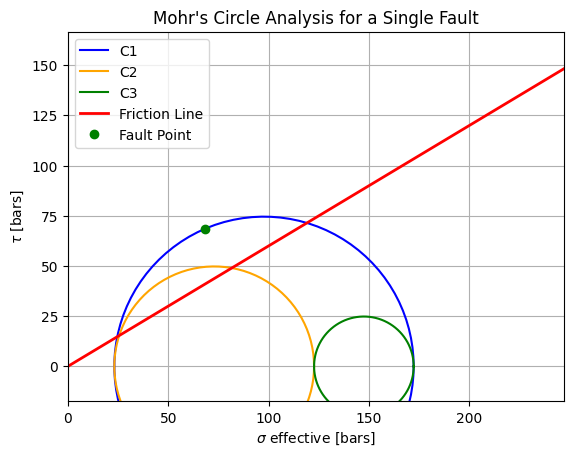

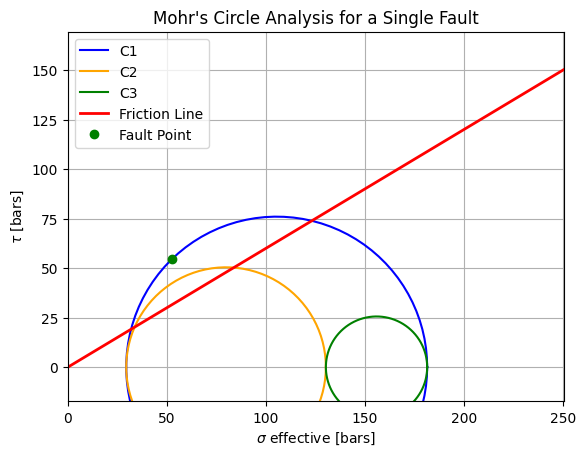

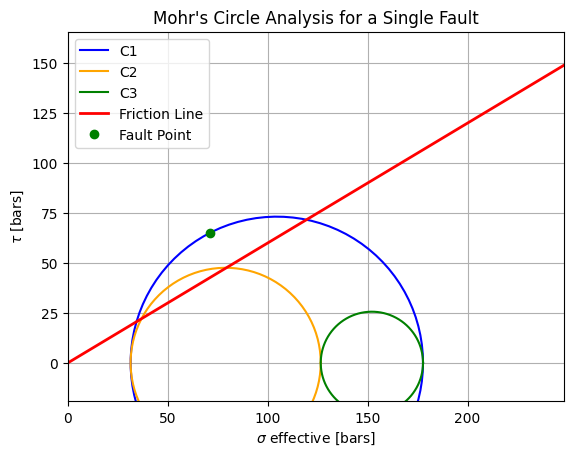

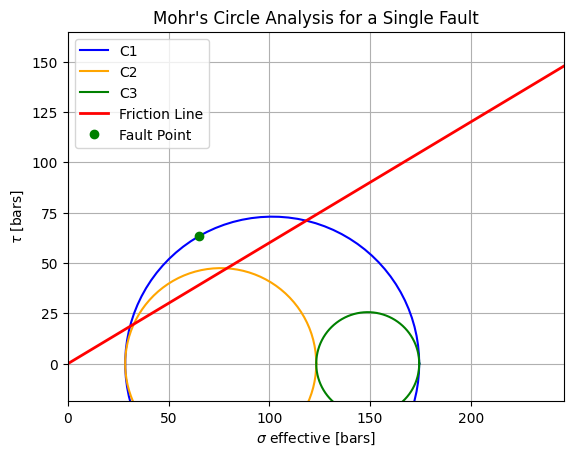

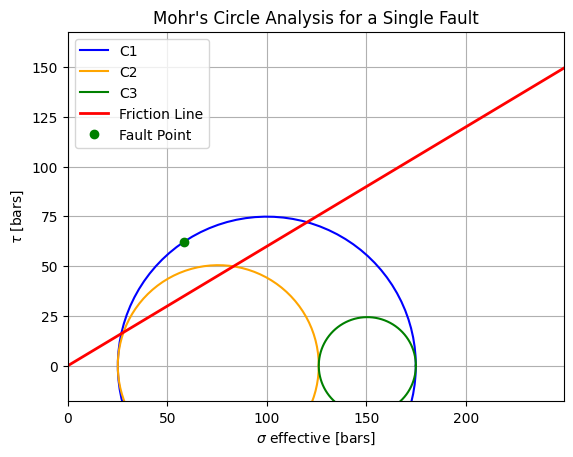

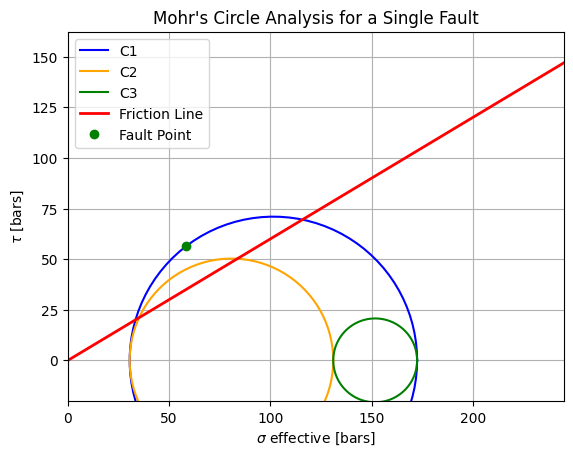

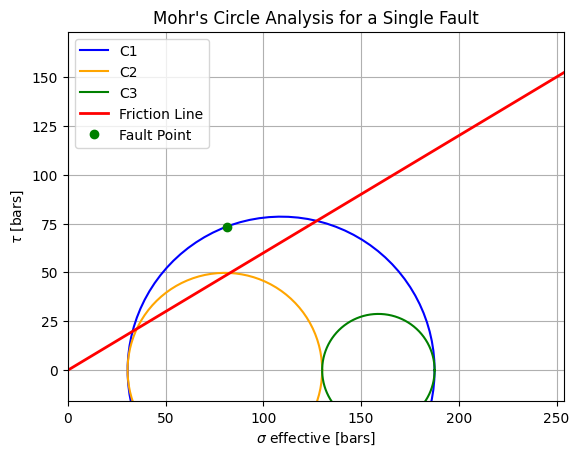

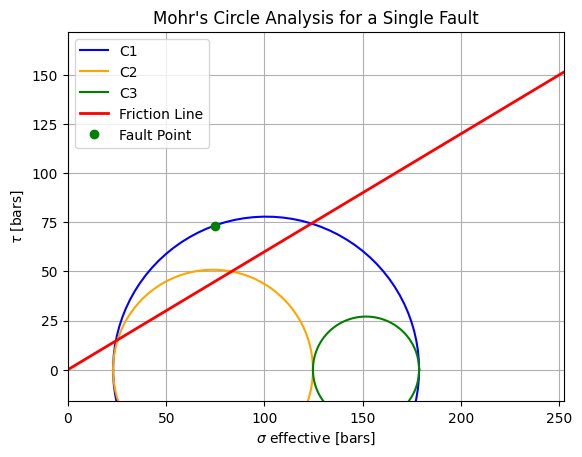

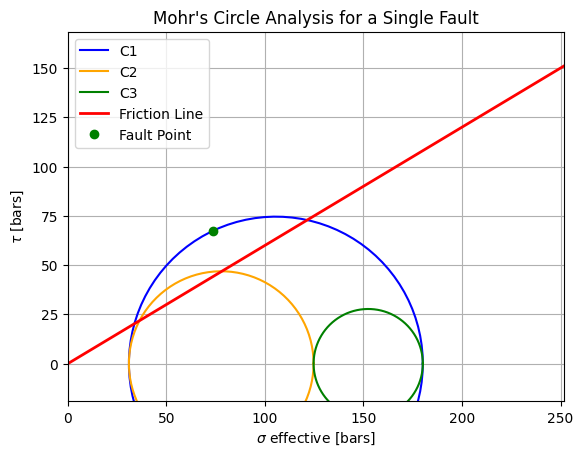

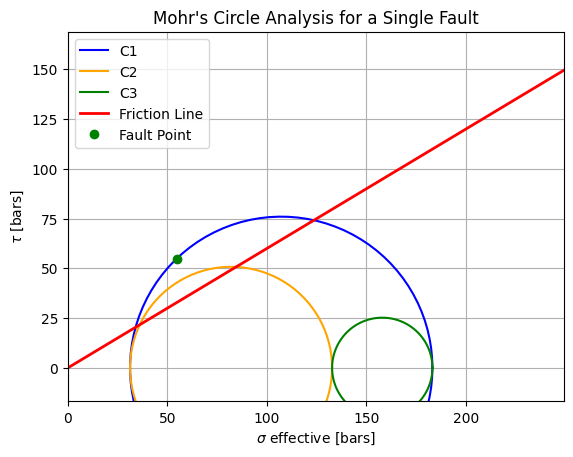

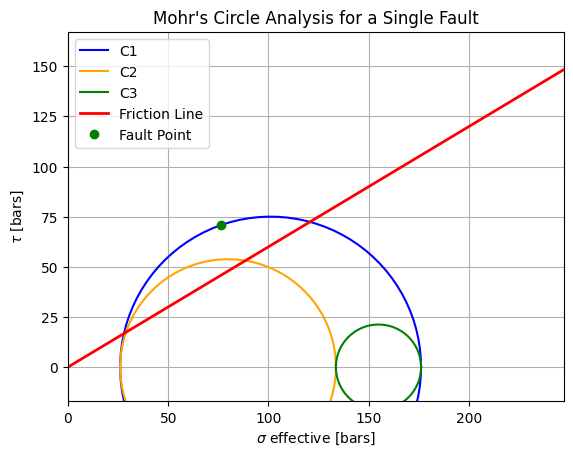

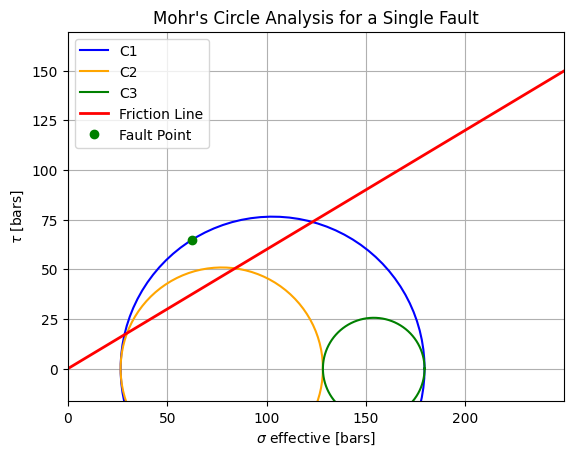

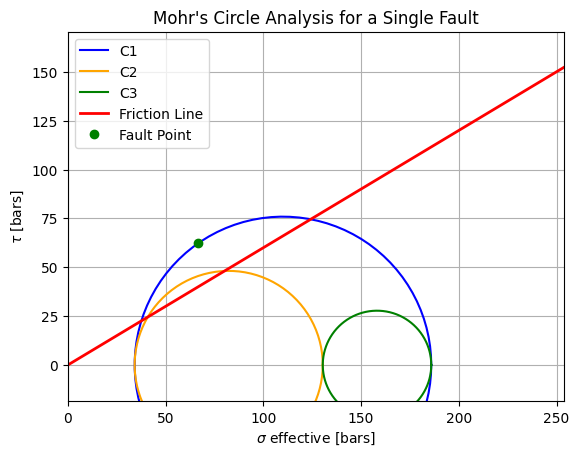

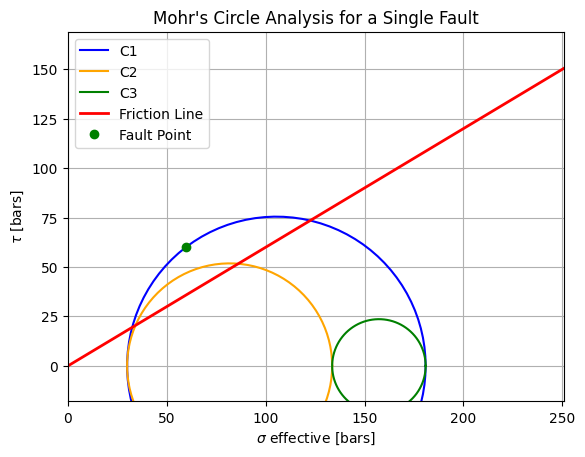

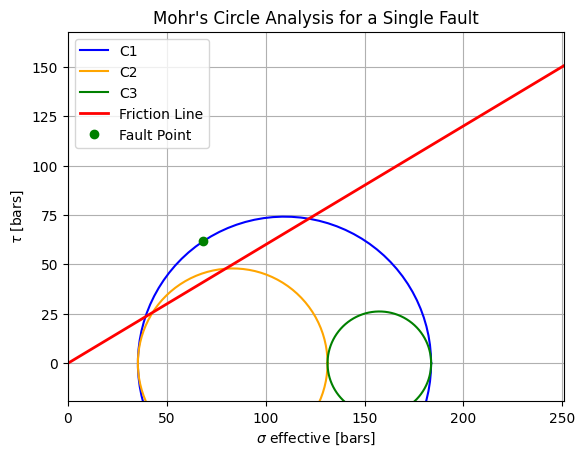

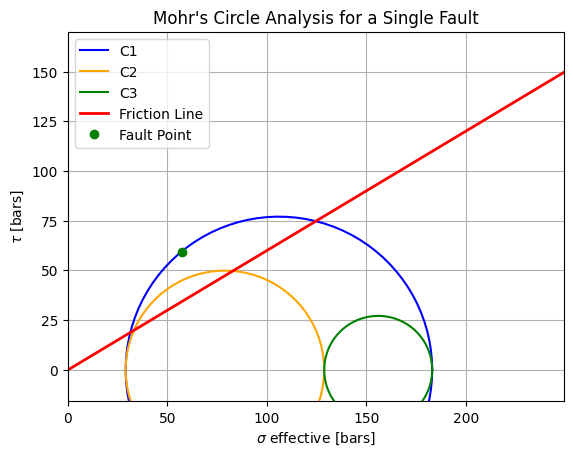

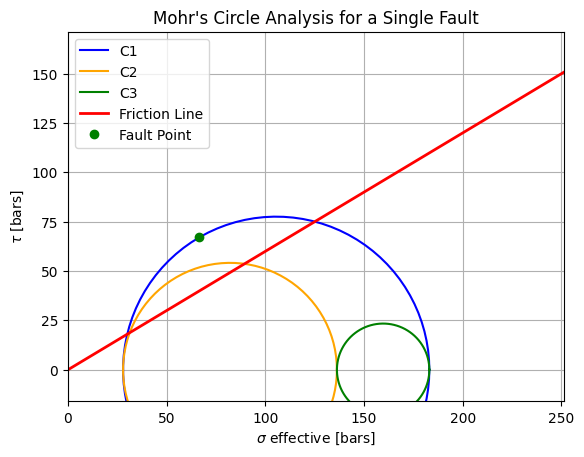

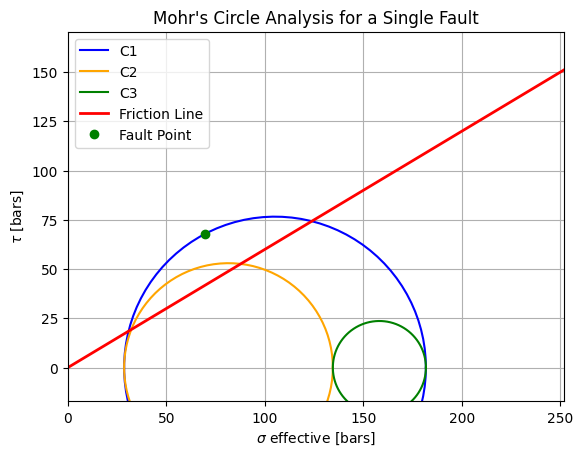

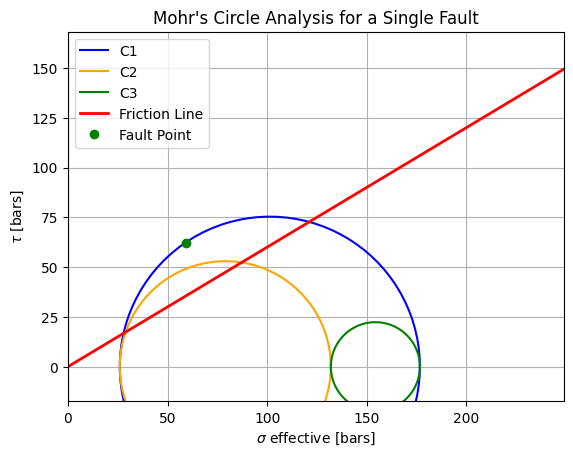

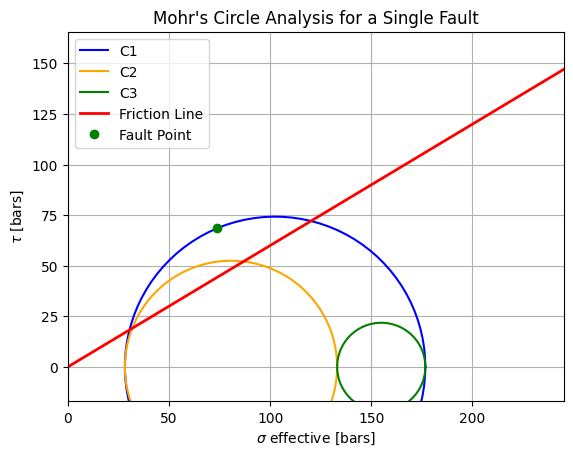

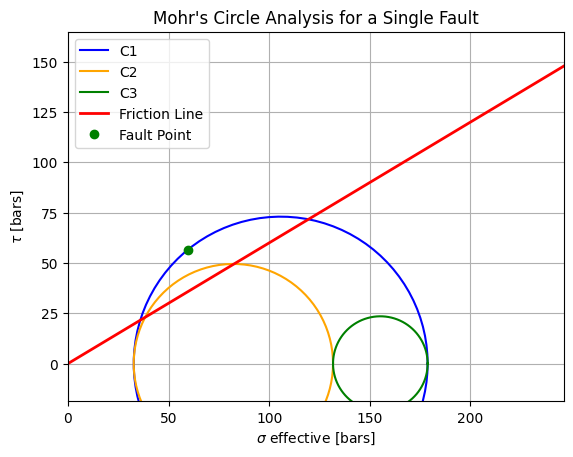

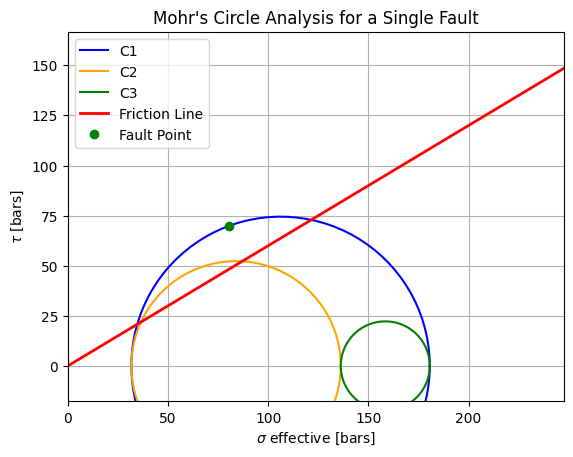

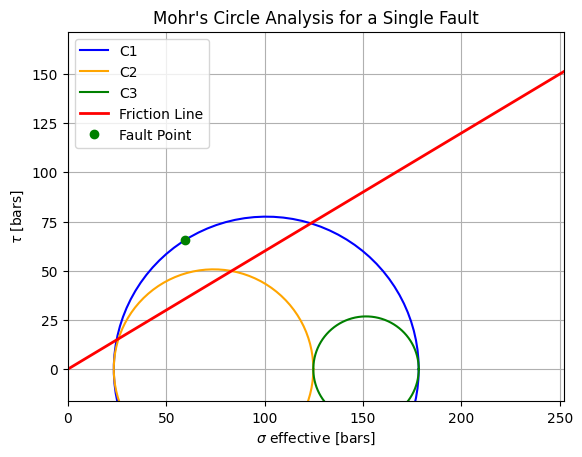

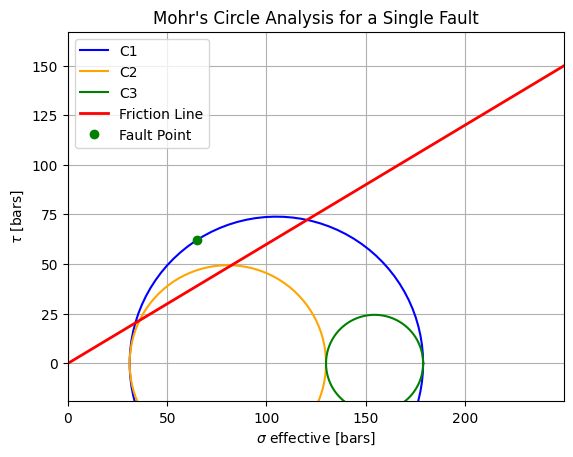

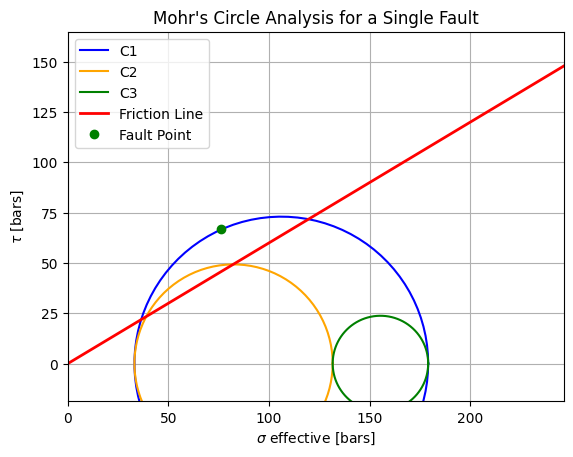

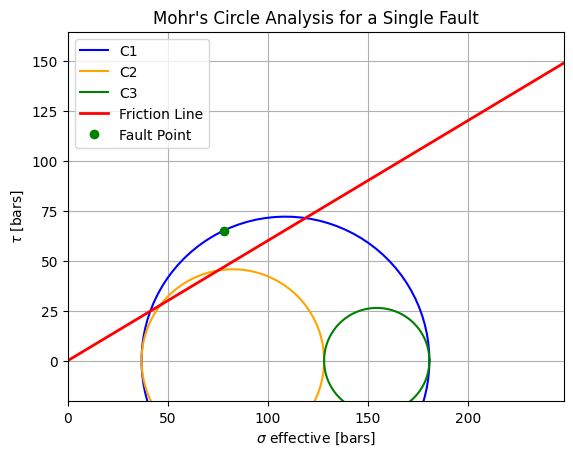

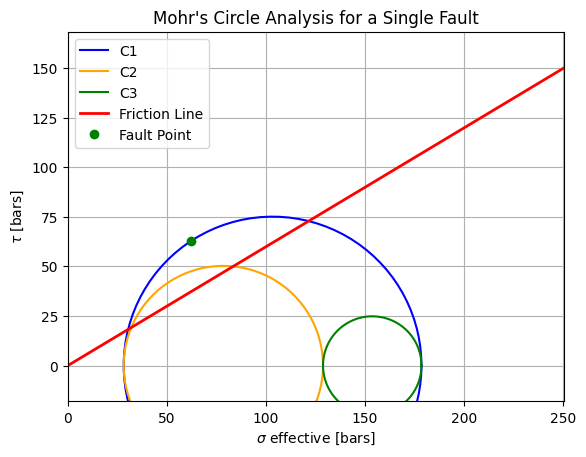

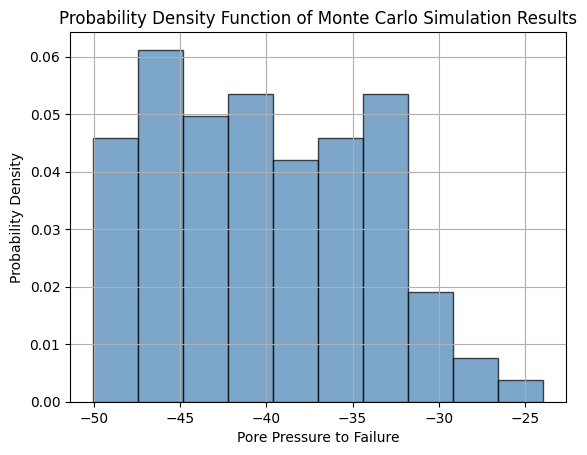

In [60]:
Sig01 = 250
Sig02 = 200
Sig03 = 100
ixSv = 2
strike = 90
dip = 90
SHdir = 60
p0 = 10
dp = 60
mu = 0.6

indatacell = [Sig01, Sig02, Sig03, ixSv, strike, dip, SHdir, p0, dp, mu]
sigcell = [5, 5, 5, 0, 5, 5, 5, 0, 5, 0]
ppfail, cff, scu, sig_fault, tau_fault = mohrs_3D_v2(Sig01, Sig02, Sig03, ixSv, strike, dip, SHdir, p0, dp, mu, APhi = None, ref_mu = None, biot = 1, nu = 0.5)
outs, inj = ppfail_MC(indatacell, sigcell, 100, "Uniform")